# Testing framework for comparison of pytorch and candle results

<a target="_blank" href="https://colab.research.google.com/github/KGrewal1/optimisers/blob/master/lbfgs_test.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>

## Imports

In [19]:
import torch
from torch import optim
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.get_device_name(0)) # this should be commented out to run on colab

2.1.0
12.1
NVIDIA GeForce RTX 3070 Ti


In [20]:
import torch
from functools import reduce
from torch.optim.optimizer import Optimizer

__all__ = ['myLBFGS']

def _cubic_interpolate(x1, f1, g1, x2, f2, g2, bounds=None):
    # ported from https://github.com/torch/optim/blob/master/polyinterp.lua
    # Compute bounds of interpolation area
    if bounds is not None:
        xmin_bound, xmax_bound = bounds
    else:
        xmin_bound, xmax_bound = (x1, x2) if x1 <= x2 else (x2, x1)

    # Code for most common case: cubic interpolation of 2 points
    #   w/ function and derivative values for both
    # Solution in this case (where x2 is the farthest point):
    #   d1 = g1 + g2 - 3*(f1-f2)/(x1-x2);
    #   d2 = sqrt(d1^2 - g1*g2);
    #   min_pos = x2 - (x2 - x1)*((g2 + d2 - d1)/(g2 - g1 + 2*d2));
    #   t_new = min(max(min_pos,xmin_bound),xmax_bound);
    d1 = g1 + g2 - 3 * (f1 - f2) / (x1 - x2)
    d2_square = d1**2 - g1 * g2
    if d2_square >= 0:
        d2 = d2_square.sqrt()
        if x1 <= x2:
            min_pos = x2 - (x2 - x1) * ((g2 + d2 - d1) / (g2 - g1 + 2 * d2))
        else:
            min_pos = x1 - (x1 - x2) * ((g1 + d2 - d1) / (g1 - g2 + 2 * d2))
        return min(max(min_pos, xmin_bound), xmax_bound)
    else:
        return (xmin_bound + xmax_bound) / 2.


def _strong_wolfe(obj_func,
                  x,
                  t,
                  d,
                  f,
                  g,
                  gtd,
                  c1=1e-4,
                  c2=0.9,
                  tolerance_change=1e-9,
                  max_ls=25):
    # ported from https://github.com/torch/optim/blob/master/lswolfe.lua
    d_norm = d.abs().max()
    g = g.clone(memory_format=torch.contiguous_format)
    # evaluate objective and gradient using initial step
    f_new, g_new = obj_func(x, t, d)
    ls_func_evals = 1
    gtd_new = g_new.dot(d)

    # bracket an interval containing a point satisfying the Wolfe criteria
    t_prev, f_prev, g_prev, gtd_prev = 0, f, g, gtd
    done = False
    ls_iter = 0
    while ls_iter < max_ls:
        # check conditions
        if f_new > (f + c1 * t * gtd) or (ls_iter > 1 and f_new >= f_prev):
            bracket = [t_prev, t]
            bracket_f = [f_prev, f_new]
            bracket_g = [g_prev, g_new.clone(memory_format=torch.contiguous_format)]
            bracket_gtd = [gtd_prev, gtd_new]
            break

        if abs(gtd_new) <= -c2 * gtd:
            bracket = [t]
            bracket_f = [f_new]
            bracket_g = [g_new]
            done = True
            break

        if gtd_new >= 0:
            bracket = [t_prev, t]
            bracket_f = [f_prev, f_new]
            bracket_g = [g_prev, g_new.clone(memory_format=torch.contiguous_format)]
            bracket_gtd = [gtd_prev, gtd_new]
            break

        # interpolate
        min_step = t + 0.01 * (t - t_prev)
        max_step = t * 10
        tmp = t
        t = _cubic_interpolate(
            t_prev,
            f_prev,
            gtd_prev,
            t,
            f_new,
            gtd_new,
            bounds=(min_step, max_step))

        # next step
        t_prev = tmp
        f_prev = f_new
        g_prev = g_new.clone(memory_format=torch.contiguous_format)
        gtd_prev = gtd_new
        f_new, g_new = obj_func(x, t, d)
        ls_func_evals += 1
        gtd_new = g_new.dot(d)
        ls_iter += 1

    # reached max number of iterations?
    if ls_iter == max_ls:
        bracket = [0, t]
        bracket_f = [f, f_new]
        bracket_g = [g, g_new]

    # zoom phase: we now have a point satisfying the criteria, or
    # a bracket around it. We refine the bracket until we find the
    # exact point satisfying the criteria
    insuf_progress = False
    # find high and low points in bracket
    low_pos, high_pos = (0, 1) if bracket_f[0] <= bracket_f[-1] else (1, 0)
    while not done and ls_iter < max_ls:
        # line-search bracket is so small
        if abs(bracket[1] - bracket[0]) * d_norm < tolerance_change:
            break

        # compute new trial value
        t = _cubic_interpolate(bracket[0], bracket_f[0], bracket_gtd[0],
                               bracket[1], bracket_f[1], bracket_gtd[1])

        # test that we are making sufficient progress:
        # in case `t` is so close to boundary, we mark that we are making
        # insufficient progress, and if
        #   + we have made insufficient progress in the last step, or
        #   + `t` is at one of the boundary,
        # we will move `t` to a position which is `0.1 * len(bracket)`
        # away from the nearest boundary point.
        eps = 0.1 * (max(bracket) - min(bracket))
        if min(max(bracket) - t, t - min(bracket)) < eps:
            # interpolation close to boundary
            if insuf_progress or t >= max(bracket) or t <= min(bracket):
                # evaluate at 0.1 away from boundary
                if abs(t - max(bracket)) < abs(t - min(bracket)):
                    t = max(bracket) - eps
                else:
                    t = min(bracket) + eps
                insuf_progress = False
            else:
                insuf_progress = True
        else:
            insuf_progress = False

        # Evaluate new point
        f_new, g_new = obj_func(x, t, d)
        ls_func_evals += 1
        gtd_new = g_new.dot(d)
        ls_iter += 1

        if f_new > (f + c1 * t * gtd) or f_new >= bracket_f[low_pos]:
            # Armijo condition not satisfied or not lower than lowest point
            bracket[high_pos] = t
            bracket_f[high_pos] = f_new
            bracket_g[high_pos] = g_new.clone(memory_format=torch.contiguous_format)
            bracket_gtd[high_pos] = gtd_new
            low_pos, high_pos = (0, 1) if bracket_f[0] <= bracket_f[1] else (1, 0)
        else:
            if abs(gtd_new) <= -c2 * gtd:
                # Wolfe conditions satisfied
                done = True
            elif gtd_new * (bracket[high_pos] - bracket[low_pos]) >= 0:
                # old high becomes new low
                bracket[high_pos] = bracket[low_pos]
                bracket_f[high_pos] = bracket_f[low_pos]
                bracket_g[high_pos] = bracket_g[low_pos]
                bracket_gtd[high_pos] = bracket_gtd[low_pos]

            # new point becomes new low
            bracket[low_pos] = t
            bracket_f[low_pos] = f_new
            bracket_g[low_pos] = g_new.clone(memory_format=torch.contiguous_format)
            bracket_gtd[low_pos] = gtd_new

    # return stuff
    t = bracket[low_pos]
    f_new = bracket_f[low_pos]
    g_new = bracket_g[low_pos]
    return f_new, g_new, t, ls_func_evals


class myLBFGS(Optimizer):
    """Implements L-BFGS algorithm, heavily inspired by `minFunc
    <https://www.cs.ubc.ca/~schmidtm/Software/minFunc.html>`_.

    .. warning::
        This optimizer doesn't support per-parameter options and parameter
        groups (there can be only one).

    .. warning::
        Right now all parameters have to be on a single device. This will be
        improved in the future.

    .. note::
        This is a very memory intensive optimizer (it requires additional
        ``param_bytes * (history_size + 1)`` bytes). If it doesn't fit in memory
        try reducing the history size, or use a different algorithm.

    Args:
        lr (float): learning rate (default: 1)
        max_iter (int): maximal number of iterations per optimization step
            (default: 20)
        max_eval (int): maximal number of function evaluations per optimization
            step (default: max_iter * 1.25).
        tolerance_grad (float): termination tolerance on first order optimality
            (default: 1e-7).
        tolerance_change (float): termination tolerance on function
            value/parameter changes (default: 1e-9).
        history_size (int): update history size (default: 100).
        line_search_fn (str): either 'strong_wolfe' or None (default: None).
    """

    def __init__(self,
                 params,
                 lr=1,
                 max_iter=20,
                 max_eval=None,
                 tolerance_grad=1e-7,
                 tolerance_change=1e-9,
                 history_size=100,
                 line_search_fn=None):
        if max_eval is None:
            max_eval = max_iter * 5 // 4
        defaults = dict(
            lr=lr,
            max_iter=max_iter,
            max_eval=max_eval,
            tolerance_grad=tolerance_grad,
            tolerance_change=tolerance_change,
            history_size=history_size,
            line_search_fn=line_search_fn)
        super().__init__(params, defaults)

        if len(self.param_groups) != 1:
            raise ValueError("LBFGS doesn't support per-parameter options "
                             "(parameter groups)")

        self._params = self.param_groups[0]['params']
        self._numel_cache = None

    def _numel(self):
        if self._numel_cache is None:
            self._numel_cache = reduce(lambda total, p: total + p.numel(), self._params, 0)
        return self._numel_cache

    def _gather_flat_grad(self):
        views = []
        for p in self._params:
            if p.grad is None:
                view = p.new(p.numel()).zero_()
            elif p.grad.is_sparse:
                view = p.grad.to_dense().view(-1)
            else:
                view = p.grad.view(-1)
            views.append(view)
        return torch.cat(views, 0)

    def _add_grad(self, step_size, update):
        offset = 0
        for p in self._params:
            numel = p.numel()
            # view as to avoid deprecated pointwise semantics
            p.add_(update[offset:offset + numel].view_as(p), alpha=step_size)
            offset += numel
        assert offset == self._numel()

    def _clone_param(self):
        return [p.clone(memory_format=torch.contiguous_format) for p in self._params]

    def _set_param(self, params_data):
        for p, pdata in zip(self._params, params_data):
            p.copy_(pdata)

    def _directional_evaluate(self, closure, x, t, d):
        self._add_grad(t, d)
        loss = float(closure())
        flat_grad = self._gather_flat_grad()
        self._set_param(x)
        return loss, flat_grad

    @torch.no_grad()
    def step(self, closure):
        """Performs a single optimization step.

        Args:
            closure (Callable): A closure that reevaluates the model
                and returns the loss.
        """
        assert len(self.param_groups) == 1

        # Make sure the closure is always called with grad enabled
        closure = torch.enable_grad()(closure)

        group = self.param_groups[0]
        lr = group['lr']
        max_iter = group['max_iter']
        max_eval = group['max_eval']
        tolerance_grad = group['tolerance_grad']
        tolerance_change = group['tolerance_change']
        line_search_fn = group['line_search_fn']
        history_size = group['history_size']

        # NOTE: LBFGS has only global state, but we register it as state for
        # the first param, because this helps with casting in load_state_dict
        state = self.state[self._params[0]]
        state.setdefault('func_evals', 0)
        state.setdefault('n_iter', 0)

        # evaluate initial f(x) and df/dx
        orig_loss = closure()
        loss = float(orig_loss)
        print("loss ", loss)
        current_evals = 1
        state['func_evals'] += 1
        # print("evals ", state['func_evals'])

        flat_grad = self._gather_flat_grad()
        print("grad ", flat_grad)
        opt_cond = flat_grad.abs().max() <= tolerance_grad

        # optimal condition
        if opt_cond:
            return orig_loss

        # tensors cached in state (for tracing)
        d = state.get('d')
        t = state.get('t')
        old_dirs = state.get('old_dirs')
        old_stps = state.get('old_stps')
        ro = state.get('ro')
        H_diag = state.get('H_diag')
        prev_flat_grad = state.get('prev_flat_grad')
        prev_loss = state.get('prev_loss')

        n_iter = 0
        # optimize for a max of max_iter iterations
        # print("max iter ", max_iter)
        while n_iter < max_iter:
            # keep track of nb of iterations
            n_iter += 1
            state['n_iter'] += 1

            ############################################################
            # compute gradient descent direction
            ############################################################
            if state['n_iter'] == 1:
                d = flat_grad.neg()
                old_dirs = []
                old_stps = []
                ro = []
                H_diag = 1
            else:
                # do lbfgs update (update memory)
                y = flat_grad.sub(prev_flat_grad) # the change in gradient
                s = d.mul(t) # the previous step direction times its length
                ys = y.dot(s)  # y*s
                print("y ", y)
                print("s ", s)
                print("numr ", ys)
                print("denom ", y.dot(y))
                if ys > 1e-10:
                    # updating memory
                    if len(old_dirs) == history_size:
                        # shift history by one (limited-memory)
                        old_dirs.pop(0)
                        old_stps.pop(0)
                        ro.pop(0)

                    # store new direction/step
                    old_dirs.append(y)
                    old_stps.append(s)
                    ro.append(1. / ys)

                    # update scale of initial Hessian approximation
                    H_diag = ys / y.dot(y)  # (y*y)
                print("gamma ", H_diag)
                # compute the approximate (L-BFGS) inverse Hessian
                # multiplied by the gradient
                num_old = len(old_dirs)

                if 'al' not in state:
                    state['al'] = [None] * history_size
                al = state['al']

                # iteration in L-BFGS loop collapsed to use just one buffer
                q = flat_grad.neg()
                for i in range(num_old - 1, -1, -1):
                    print("rho ", ro[i])
                    al[i] = old_stps[i].dot(q) * ro[i]
                    q.add_(old_dirs[i], alpha=-al[i])
                print("q after loop 1: ", q)
                # multiply by initial Hessian
                # r/d is the final direction
                d = r = torch.mul(q, H_diag)
                print("q before loop 2: ", r)
                # print("q before loop 2: ", d)
                for i in range(num_old):
                    be_i = old_dirs[i].dot(r) * ro[i]
                    r.add_(old_stps[i], alpha=al[i] - be_i)
                print("q after loop 2: ", r)
                # print("q after loop 2: ", d)
            if prev_flat_grad is None:
                prev_flat_grad = flat_grad.clone(memory_format=torch.contiguous_format)
            else:
                prev_flat_grad.copy_(flat_grad)
            prev_loss = loss

            ############################################################
            # compute step length
            ############################################################
            # reset initial guess for step size
            if state['n_iter'] == 1:
                t = min(1., 1. / flat_grad.abs().sum()) * lr
            else:
                t = lr

            # print("evals 2", state['func_evals'])

            # directional derivative
            gtd = flat_grad.dot(d)  # g * d

            # directional derivative is below tolerance
            if gtd > -tolerance_change:
                break

            # optional line search: user function
            ls_func_evals = 0
            if line_search_fn is not None:
                # perform line search, using user function
                if line_search_fn != "strong_wolfe":
                    raise RuntimeError("only 'strong_wolfe' is supported")
                else:
                    x_init = self._clone_param()

                    def obj_func(x, t, d):
                        return self._directional_evaluate(closure, x, t, d)

                    loss, flat_grad, t, ls_func_evals = _strong_wolfe(
                        obj_func, x_init, t, d, loss, flat_grad, gtd)
                self._add_grad(t, d)
                opt_cond = flat_grad.abs().max() <= tolerance_grad
            else:
                # no line search, simply move with fixed-step
                print("t", t)
                print("step", d.mul(t))
                self._add_grad(t, d)
                if n_iter != max_iter:
                    # re-evaluate function only if not in last iteration
                    # the reason we do this: in a stochastic setting,
                    # no use to re-evaluate that function here
                    with torch.enable_grad():
                        loss = float(closure())
                    flat_grad = self._gather_flat_grad()
                    opt_cond = flat_grad.abs().max() <= tolerance_grad
                    ls_func_evals = 1

            # update func eval
            current_evals += ls_func_evals
            state['func_evals'] += ls_func_evals

            ############################################################
            # check conditions
            ############################################################
            if n_iter == max_iter:
                break

            if current_evals >= max_eval:
                break

            # optimal condition
            if opt_cond:
                break

            # lack of progress
            if d.mul(t).abs().max() <= tolerance_change:
                break

            if abs(loss - prev_loss) < tolerance_change:
                break

        state['d'] = d
        state['t'] = t
        state['old_dirs'] = old_dirs
        state['old_stps'] = old_stps
        state['ro'] = ro
        state['H_diag'] = H_diag
        state['prev_flat_grad'] = prev_flat_grad
        state['prev_loss'] = prev_loss

        return orig_loss


# LBFGS tests

## rosenbrcck
from https://gist.github.com/tuelwer/0b52817e9b6251d940fd8e2921ec5e20


start step 0
tensor([[10.],
        [10.]], requires_grad=True)
loss  810081.0
grad  tensor([360018., -18000.])
t tensor(2.6454e-06)
step tensor([-0.9524,  0.0476])

start step 1
tensor([[ 9.0476],
        [10.0476]], requires_grad=True)
loss  515757.625
grad  tensor([259906.2031, -14362.3516])
y  tensor([-100111.7969,    3637.6484])
s  tensor([-0.9524,  0.0476])
numr  tensor(95518.0078)
denom  tensor(1.0036e+10)
gamma  tensor(9.5179e-06)
rho  tensor(1.0469e-05)
q after loop 1:  tensor([ 245.4729, 4909.5161])
q before loop 2:  tensor([0.0023, 0.0467])
q after loop 2:  tensor([-2.4732,  0.1705])
t 1
step tensor([-2.4732,  0.1705])

start step 2
tensor([[ 6.5744],
        [10.2181]], requires_grad=True)
loss  108965.21875
grad  tensor([86807.3828, -6601.0347])
y  tensor([-173098.8125,    7761.3169])
s  tensor([-2.4732,  0.1705])
numr  tensor(429426.9375)
denom  tensor(3.0023e+10)
gamma  tensor(1.4303e-05)
rho  tensor(2.3287e-06)
rho  tensor(1.0469e-05)
q after loop 1:  tensor([ 135.1091

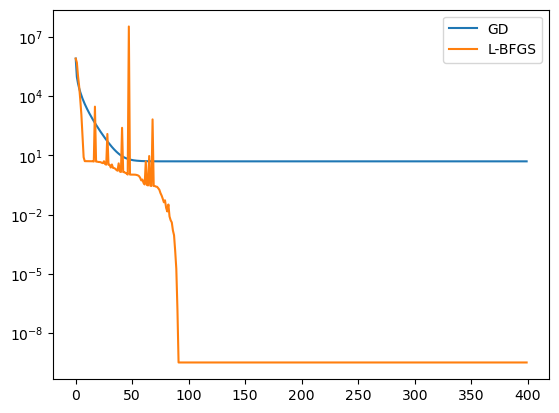

tensor([[1.0000],
        [1.0000]], requires_grad=True)


In [21]:
import matplotlib.pyplot as plt


# 2d Rosenbrock function
def f(x):
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2


# Gradient descent
x_gd = 10*torch.ones(2, 1)
x_gd.requires_grad = True
gd = optim.SGD([x_gd], lr=1e-5)
history_gd = []
for i in range(400):
    gd.zero_grad()
    objective = f(x_gd)
    objective.backward()
    gd.step()
    history_gd.append(objective.item())


# L-BFGS
def closure():
    lbfgs.zero_grad()
    objective = f(x_lbfgs)
    objective.backward()
    return objective

x_lbfgs = 10*torch.ones(2, 1)

x_lbfgs.requires_grad = True

lbfgs = myLBFGS([x_lbfgs],
                    history_size=100,
                    max_iter=1)
# ,
#                     line_search_fn="strong_wolfe"

history_lbfgs = []
for i in range(400):
    print("\nstart step", i)
    print(x_lbfgs)
    # print(lbfgs)
    # print(lbfgs.state)

    history_lbfgs.append(f(x_lbfgs).item())
    lbfgs.step(closure)
    # for state in lbfgs.state.values():
    #     for key, value in state.items():
    #         print(key, ' ', value)


# Plotting
plt.semilogy(history_gd, label='GD')
plt.semilogy(history_lbfgs, label='L-BFGS')
plt.legend()
plt.show()

print(x_lbfgs)